## Text DNN

### Numpy로  RNN 구현

In [1]:
import numpy as np

In [2]:
# 입력데이터
timesteps = 10
input_dim = 4 # m (임베딩에서는 아웃풋차원, RNN에서는 인풋차원)

# cell
hidden_size = 8 # 메모리 cell의 용량

In [3]:
inputs = np.random.random((timesteps, input_dim))
hidden_state_t = np.zeros((hidden_size))

Wx = np.random.random((input_dim, hidden_size)) # X @ W
Wh = np.random.random((hidden_size, hidden_size))
b = np.random.random((hidden_size))

In [4]:
total_hidden_state = []
# RNN unroll
for inp in inputs:
    output_t = np.tanh(np.dot(hidden_state_t, Wh) + np.dot(inp, Wx) + b)
    total_hidden_state.append(list(output_t))
    
    print(np.shape(total_hidden_state))

    hidden_state_t = output_t # h_t-1

(1, 8)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)


### TF로 RNN 구현

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN

model = Sequential([
    #hidden unit, timesteps, m(input_dim) 
    SimpleRNN(3, input_shape=(2, 10), return_sequences=True)
])
model.summary() # 30 + 9 + 3

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 2, 3)              42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### RNN 구현에 중요 팁
- return_sequences=True??   
> 각 timestep마다 y를 리턴함
- y_t와 h_t는 본질적으로 같다  
> 단지, y_t는 활성화함수를 입힐 수 있을 뿐!

In [6]:
hidden_size = 8

model = Sequential()
model.add(SimpleRNN(hidden_size, return_sequences=True))
model.add(SimpleRNN(10, return_sequences=True))


#### Bidirectional RNN
- return_sequences=True 필수!

In [7]:
from tensorflow.keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(SimpleRNN(3, return_sequences=True), input_shape=(2, 10)))
model.summary() # Output_Shape (Batch, Cell 개수, 뉴런개수(*2))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 6)              84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = Sequential([
    Bidirectional(SimpleRNN(8, return_sequences=True), input_shape=(2, 10)),
    Bidirectional(SimpleRNN(100, return_sequences=True))
])
model.summary()
# 파라미터 1층 : (160 + 128 + 16) * 2
# 파라미터 2층 : 2*16*100 + 2*100*100 + 2*100

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 2, 16)             304       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2, 200)            23400     
Total params: 23,704
Trainable params: 23,704
Non-trainable params: 0
_________________________________________________________________


##  한글 분류 실습

- 출력층에 sigmoid로 긍정/부정 판단

In [9]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

okt = Okt()
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x2b4d9ae1460>)

In [10]:
df_train = pd.read_table('ratings_train.txt')
df_test = pd.read_table('ratings_test.txt')

In [11]:
df_train.info()
df_train.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


id          150000
document    146182
label            2
dtype: int64

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### 분석 계획
1. 중복데이터 확인
2. 레이블의 비율 확인
3. null 제거
4. 텍스트 정제(norm, stem, stopword)

#### 중복데이터 확인

In [13]:
# 중복데이터 확인, 클래스 개수 확인
df_train['document'].nunique(), df_train['label'].nunique()

(146182, 2)

In [14]:
df_train.drop_duplicates(subset=['document'], inplace=True)
df_train.nunique()

id          146183
document    146182
label            2
dtype: int64

#### 레이블 비율 확인

<AxesSubplot:>

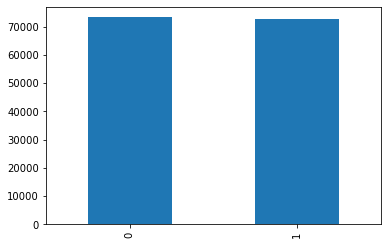

In [15]:
# 레이블 비율 확인
df_train['label'].value_counts().plot(kind='bar')

#### Null 제거

In [16]:
df_train = df_train.dropna(how='any')
df_train.isnull().values.sum()

0

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### 텍스트 정제

In [18]:
# 텍스트 정제
df_train['document'] = df_train['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
df_train['document'] = df_train['document'].replace('', np.nan)
df_train = df_train.dropna(how='any') # str쓰면 str만 들가야함
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145791 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145791 non-null  int64 
 1   document  145791 non-null  object
 2   label     145791 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [19]:
# from hanspell import spell_checker
# df_train['document'].apply([lambda x: spell_checker.check(x).checked for x in df_train['document']])

##### 테스트 데이터도 동일하게 처리

In [54]:
df_test = pd.read_table('ratings_test.txt')

df_test.drop_duplicates(subset=['document'], inplace=True)
df_test['document'] = df_test['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
df_test['document'] = df_test['document'].replace('', np.nan)
df_test.dropna(how='any', inplace=True)

##### 불용어 처리

In [21]:
from tqdm import tqdm_notebook

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = [] #[[단어1, 단어2], [단어1, 단어2, 단어3], ...]
for sent in tqdm_notebook(df_train['document']):
    X_temp = [] # 리스트 안에 있는 단어
    X_temp = okt.morphs(sent, norm=True, stem=True)
    X_temp = [w for w in X_temp if not w in stopwords]
    X_train.append(X_temp)
X_train

<ipython-input-21-7265809ec708>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sent in tqdm_notebook(df_train['document']):


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '부터',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '아깝다',
  '움'],
 ['원작', '긴장감', '을', '제대로', '살리다'],
 ['별',
  '반개',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '없다',
  '연기',
  '못',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '없다', '재미', '있다', '몇', '안되다', '영화'],
 ['왜',
  '이렇게',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '데',
  '헐리우드',
  '식',
  '화려하다',
  '너무',
  '길들이다',
  '있다'],
 ['인피니트', '짱', '이다', '진짜', '짱', '이다'],
 ['볼때',
  '마다',


이건 cpu연산이다 형태소 분리는 gpu 안씀!

In [92]:
X_test = []
for sent in tqdm_notebook(df_test['document']):
    X_temp = []
    X_temp = okt.morphs(sent, norm=True, stem=True)
    X_temp = [w for w in X_temp if not w in stopwords]
    X_test.append(X_temp)
X_test

<ipython-input-92-7492a755f79e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sent in tqdm_notebook(df_test['document']):


[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다'],
 ['음악', '주가', '되다', '최고', '음악', '영화'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '젖다'],
 ['갈수록',
  '개판',
  '되다',
  '중국영화',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '안되다',
  '무기',
  '유치하다',
  '남무',
  '아',
  '그리다',
  '동사서독',
  '같다',
  '영화',
  '것',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', '모든', '사람', '그렇다', '않다'],
 ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요'],
 ['한국', '독립영화', '한계', '그렇게', '아버지', '되다', '비교', '되다'],
 ['청춘',
  '아름답다',
  '그',
  '아름답다',
  '움',
  '이성',
  '을',
  '흔들다',
  '놓다',
  '찰나',
  '아름답다',
  '움',
  '을',
  '자다',
  '포착',
  '섬세하다',
  '아름답다',
  '수채화',
  '같다',
  '퀴어',
  '영화',
  '이다'],
 ['눈', '보이다', '반전', '이다', '영화', '흡인', '력', '사라지다', '않다'],
 ['스토리',

### 단어집합 생성

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '재밌다': 9, '다': 10, '정말': 11, '것': 12, '되다': 13, '적': 14, '만': 15, '같다': 16, '진짜': 17, '아니다': 18, '않다': 19, '로': 20, '점': 21, '에서': 22, '만들다': 23, '나오다': 24, '연기': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '왜': 33, '스토리': 34, '생각': 35, '못': 36, '드라마': 37, '감동': 38, '사람': 39, '게': 40, '보고': 41, 'ㅋㅋㅋ': 42, '말': 43, '이렇다': 44, '아깝다': 45, '고': 46, '더': 47, '배우': 48, '때': 49, 'ㅋㅋ': 50, '아': 51, '감독': 52, '거': 53, '그냥': 54, '재미있다': 55, '뭐': 56, '시간': 57, '재미': 58, '내용': 59, '요': 60, '까지': 61, '주다': 62, '중': 63, '자다': 64, '하고': 65, '지루하다': 66, '재미없다': 67, '쓰레기': 68, '수': 69, '네': 70, '가다': 71, '모르다': 72, '들다': 73, '그렇다': 74, '싶다': 75, '작품': 76, '알다': 77, '사랑': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '지': 83, '정도': 84, '저': 85, '처음': 86, '이렇게': 87, '완전': 88, '오다': 89, 'ㅋ': 90, 'ㅠㅠ': 91, '많다': 92, '장면': 93, '액션': 94, '주인공': 95, '안되다': 96, '차다': 97, '인데': 98, '개': 99, '하': 100, '나다': 101, '돈': 1

#### 희소 단어

In [65]:
threshold = 3 # 단어 빈도수 제한
total_cnt = len(tokenizer.word_index) # 단어개수 (단어 집합)
rare_cnt = 0 # threshold보다 빈도수 낮은 단어 count용 (단어 집합)

total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총합 (실제 사용된 단어)
rare_freq = 0 #등장 빈도수가 threshold보다 낮은 단어의 총합 (실제 사용된 단어)

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value # 모든 단어 빈도수 총합
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print('단어 집합 크기 {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀단어의 수 : {}'.format(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : {}'.format((rare_cnt / total_cnt) * 100))
print('실제 사용한 희귀 단어의 비율 : {}'.format((rare_freq /total_freq) * 100))

단어 집합 크기 42945
등장 빈도가 2번 이하인 희귀단어의 수 : 23704
단어 집합에서 희귀 단어의 비율 : 55.19618116195133
실제 사용한 희귀 단어의 비율 : 1.8288568126872522


- 55%는 임계값보다 낮은 빈도로 나온 단어다. (단어집합에서)
이 단어들을 날리면 데이터가 단순해진다.(내가 가진 docu 기준으로는 2%정도)

- 희귀단어(2번이하 등장한 단어)는 많지만, 실제로 쓰인 단어는 1.8% 밖에 안 된다

#### 희소단어를 반영해서 단어집합 생성

In [66]:
# 단어 집합에서 빈도가 3번 이상인 단어만 쓰겠다
vocab_size = total_cnt - rare_cnt + 2 #(padding, oov)
print(vocab_size)

19243


Tokenizer를 다시 만들자! vocab size를 고려해서!

참고로 패딩해야 gpu 써서 병렬연산 할 수 있다

In [67]:
tokenizer = Tokenizer(vocab_size, oov_token='<oov>') #패딩은 토큰 자동으로 인식해준다
tokenizer.fit_on_texts(X_train)

#####  주의사항 1
- train에는 없는데 test에만 있는 데이터가 있을 수 있음
- 그러니까 꼭! 같은 tokenizer 써라

In [93]:
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [69]:
X_train_encoded[:3]

[[52, 451, 18, 239, 658],
 [922, 452, 42, 604, 2, 214, 1446, 26, 953, 675, 20],
 [421, 16116, 1, 2308, 5624, 3, 224, 11]]

##### 주의사항 2
- 어어??? 희소단어로만 이루어진 문장은 정수인코딩하면 어케되는거???
- 모조리 빈 리스트로 변했다 ㄷ

In [70]:
drop_train = [idx for idx, sent in enumerate(X_train_encoded) if len(sent) < 1]
drop_train[:3]

[404, 412, 470]

In [71]:
X_train_encoded_final = np.delete(X_train_encoded, drop_train, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [72]:
X_train_encoded_final

array([list([52, 451, 18, 239, 658]),
       list([922, 452, 42, 604, 2, 214, 1446, 26, 953, 675, 20]),
       list([421, 16116, 1, 2308, 5624, 3, 224, 11]), ...,
       list([41, 57, 61, 1445, 5553, 14507, 47, 10381, 10319, 1037]),
       list([1033, 2, 2244, 2907, 1219, 539, 7790]),
       list([197, 2, 1809, 21, 1, 60, 1357, 2])], dtype=object)

#####  주의사항 3
- X데이터를 삭제했으니까 y데이터(레이블)도 삭제해줘야지

In [94]:
y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])

y_train = np.delete(y_train, drop_train, axis=0)

X_train_encoded_final.shape, y_train.shape

((145380,), (145380,))

In [95]:
drop_test = [idx for idx, sent in enumerate(X_test_encoded) if len(sent) < 1]

X_test_encoded_final = np.delete(X_test_encoded, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [96]:
X_test_encoded_final.shape, y_test.shape

((48850,), (48850,))

### 패딩

In [76]:
print('리뷰 최대 길이 : {}'.format(max(len(l) for l in X_train_encoded_final)))
print('리뷰 평균 길이 : {}'.format(sum(map(len, X_train_encoded_final)) / len(X_train_encoded_final)))

리뷰 최대 길이 : 72
리뷰 평균 길이 : 10.988072637226578


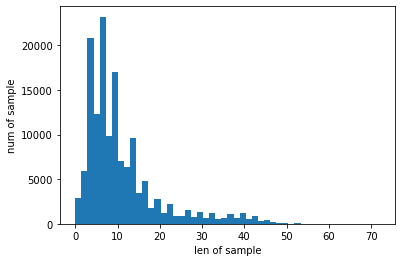

In [77]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('len of sample')
plt.ylabel('num of sample')
plt.show()

In [78]:
# max_len = threshold
def threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s) <= max_len:
            cnt += 1
    print('길이가 {} 이하인 샘플 비율 {}'.format(max_len, (cnt/len(nested_list) * 100)))

threshold_len(30, X_train_encoded_final)
threshold_len(40, X_train_encoded_final)

길이가 30 이하인 샘플 비율 94.09891319301141
길이가 40 이하인 샘플 비율 98.09877562250654


In [97]:
max_len = 30 # padding = 30

X_train_padded = pad_sequences(X_train_encoded_final, maxlen=max_len)
X_test_padded = pad_sequences(X_test_encoded_final, maxlen=max_len)

In [40]:
X_train_padded[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    52,   451,
           18,   239,   658],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   922,   452,    42,   604,     2,   214,  1446,    26,
          953,   675,    20],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   421, 16116,     1,  2308,  5624,
            3,   224,    11]])

### 모델링

In [98]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### 감성분석 == many-to-one

- bidirectional 쓰면 return_seq 켜야함
- return_seq켜면 many-to-many 나옴
- 단어마다 pred가 나오기 때문에 감성분석 불가!

In [142]:
model = Sequential([
    Embedding(vocab_size, 100),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1924300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,041,677
Trainable params: 2,041,677
Non-trainable params: 0
_________________________________________________________________


In [143]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

hist = model.fit(X_train_padded,
                y_train,
                validation_split=0.2,
                epochs=30,
                batch_size=64,
                callbacks=[es, mc])

Epoch 1/30
1818/1818 [==============================] - 54s 27ms/step - loss: 0.3846 - acc: 0.8250 - val_loss: 0.3426 - val_acc: 0.8485

Epoch 00001: val_acc improved from -inf to 0.84850, saving model to best_model.h5
Epoch 2/30
1818/1818 [==============================] - 47s 26ms/step - loss: 0.2956 - acc: 0.8731 - val_loss: 0.3461 - val_acc: 0.8521

Epoch 00002: val_acc improved from 0.84850 to 0.85215, saving model to best_model.h5
Epoch 3/30
1818/1818 [==============================] - 47s 26ms/step - loss: 0.2470 - acc: 0.8958 - val_loss: 0.3569 - val_acc: 0.8499

Epoch 00003: val_acc did not improve from 0.85215
Epoch 4/30
1818/1818 [==============================] - 47s 26ms/step - loss: 0.2057 - acc: 0.9153 - val_loss: 0.3891 - val_acc: 0.8432

Epoch 00004: val_acc did not improve from 0.85215
Epoch 5/30
1818/1818 [==============================] - 47s 26ms/step - loss: 0.1685 - acc: 0.9323 - val_loss: 0.4386 - val_acc: 0.8419

Epoch 00005: val_acc did not improve from 0.8521

In [144]:
def sent_predict(new_sent):
    new_sent = okt.morphs(new_sent, stem=True, norm=True)
    new_sent = [w for w in new_sent if not w in stopwords]
    
    encoded = tokenizer.texts_to_sequences([new_sent])
    pad_new = pad_sequences(encoded, maxlen=max_len)
    
    pred = model.predict(pad_new)
    score = float(pred)   
    
    if score > 0.5 :
        print('{:.2f} 확률로 긍정리뷰입니다'.format(score * 100))
    else:
        print('{:.2f} 확률로 부정리뷰입니다'.format((1-score) * 100))

sent_predict("영화 재밌었다")

93.00 확률로 긍정리뷰입니다
